In [1]:
import mxnet as mx
import numpy as np
from collections import namedtuple
from skimage import io
from sklearn import utils
from random import randint
from random import shuffle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DataBatch = namedtuple('DataBatch', ['data', 'label', 'pad', 'index'])
class dataiter(mx.io.DataIter):
    def __init__(self,low,high,batch_size,datatype,ctx):
        self.batch_size = batch_size
        self.reset()
        self.low = low
        self.high= high
        self.datatype = datatype   
        self.ctx = ctx
        self.get_data_dir(low,high)   
    def get_data_dir(self,low,high):
        self.img_dir = []
        for num in range(low,high):
            dir_name = '000{}'.format(num)
            if len(dir_name) == 4 :
                dir_name = '00'+dir_name
            elif len(dir_name) == 5:
                dir_name = '0'+ dir_name
            gt = './disp_noc/'+dir_name+'_10.png'.format(num)
            imgL = './colored_0/'+dir_name+'_10.png'.format(num)
            imgR = './colored_1/'+dir_name+'_10.png'.format(num)
            self.img_dir.append((gt,imgL,imgR))
        shuffle(self.img_dir) 
    def produce_patch(self,ith):
        #load img dir
        dis  = np.round(io.imread(self.img_dir[ith][0])/256.0).astype(int)
        left = io.imread(self.img_dir[ith][1]) - 128.0
        left =  left.swapaxes(2,1).swapaxes(1,0)
        right= io.imread(self.img_dir[ith][2]) - 128.0
        right= right.swapaxes(2,1).swapaxes(1,0)
        self.generate_patch_with_ground_truth(left,right,dis)  
        utils.shuffle(self.l_ls,self.r_ls,self.ld_ls,self.rd_ls,self.labels,random_state=0)

    def generate_patch_with_ground_truth(self,left,right,dis):
        scale = 6
        for y in xrange(scale,dis.shape[0]-scale):
            for x in xrange(scale,dis.shape[1]-scale):
                if dis[y,x]!=0:
                    d = dis[y,x]
                    if x-d>=scale :
                        self.l_ls.append(left[:,y-scale:y+1+scale,x-scale:x+1+scale])
                        self.r_ls.append(right[:,y-scale:y+1+scale,x-scale-d:x+1+scale-d])
                        self.ld_ls.append(left[:,y-scale:y+1+scale:2,x-scale:x+1+scale:2])
                        self.rd_ls.append(right[:,y-scale:y+1+scale:2,x-scale-d:x+1+scale-d:2])
                        self.labels.append(1)
                        while True:
                            xn = np.random.randint(scale,dis.shape[1]-scale)
                            if xn<dis.shape[1]-scale and x-d != xn:
                                break
                        self.l_ls.append( left[:,y-scale:y+1+scale,    x-scale:x+1+scale])
                        self.r_ls.append(right[:,y-scale:y+1+scale,xn-scale:xn+1+scale])
                        self.ld_ls.append(left[:,y-scale:y+scale+1:2,x-scale:x+1+scale:2])
                        self.rd_ls.append(right[:,y-scale:y+scale+1:2,xn-scale:xn+1+scale:2])
                        self.labels.append(0) 
                        self.inventory +=2     
    def reset(self):
        self.index = 0
        self.img_idx = 0
        self.inventory = 0
        self.l_ls = []
        self.r_ls = []
        self.ld_ls = []
        self.rd_ls = []
        self.labels = []

    def iter_next(self):
        if self.inventory < self.batch_size:
            if self.img_idx >= self.high:
                return False
            if self.datatype !='test':
                self.produce_patch(self.img_idx)
            else:
                self.produce_patch_test(self.img_idx)
            self.img_idx+=1
        else: 
            return True
    def getdata(self):
        left = mx.nd.array(np.asarray(self.l_ls[:self.batch_size]),ctx)
        right = mx.nd.array(np.asarray(self.l_ls[:self.batch_size]),ctx)
        left_downsample = mx.nd.array(np.asarray(self.l_ls[:self.batch_size]),ctx)
        right_downsample = mx.nd.array(np.asarray(self.l_ls[:self.batch_size]),ctx)
        del self.l_ls[:self.batch_size]
        del self.r_ls[:self.batch_size]
        del self.ld_ls[:self.batch_size]
        del self.rd_ls[:self.batch_size]
        return [left,right,left_downsample,right_downsample]
    def getlabel(self):
        if self.datatype !='test':
            result =  mx.nd.array(self.labels[:self.batch_size])
            del self.labels[:self.batch_size]
            return result
        else :
            return None
    def getindex(self):
        return self.index
    def getpad(self):
        return 0

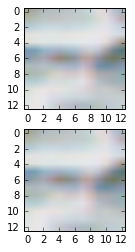

In [95]:
for batch  in train_iter:
    a = batch.data[0]
    b = batch.data[1]
    c = batch.label
    idx = randint(30,1000)
    l_p = a.asnumpy()[idx].swapaxes(0,1).swapaxes(1,2) + 128
    r_p = b.asnumpy()[idx].swapaxes(0,1).swapaxes(1,2) + 128
    plt.figure()
    p1 = plt.subplot(211)
    p2 = plt.subplot(212)
    p1.imshow(l_p)
    p2.imshow(r_p)
    break

In [24]:
def get_network():
    relu = {}
    conv = {}
    weight = {}
    bias = {}
    
    relu[0]  = mx.sym.Variable('left')
    relu[1]  = mx.sym.Variable('right')
    relu[2]  = mx.sym.Variable('left_downsample')
    relu[3]  = mx.sym.Variable('right_downsample')

    for num_layer in range(4):
        weight[0]   = mx.sym.Variable('weight%d_blue' % num_layer)
        weight[1]   =  mx.sym.Variable('weight%d_red' % num_layer)
        bias[0]    = mx.sym.Variable('bias%d_blue' % num_layer)
        bias[1]   = mx.sym.Variable('bias%d_red' % num_layer)
        if num_layer<=1:
            kernel = (3,3)
            pad = (1,1)
            num_filter = 32
        else:
            kernel = (5,5)
            pad = (2,2)
            num_filter = 200
    
        for j in range(4):
            conv[j]  = mx.sym.Convolution(data = relu[j] ,weight=weight[j/2],bias=bias[j/2],kernel=kernel,num_filter=num_filter,pad= pad)
            relu[j] =  mx.sym.Activation(data=conv[j], act_type="relu")
    flatten = {}        
    for j in range(4):
        flatten[j] = mx.sym.Flatten(data=relu[j])
    s = mx.sym.Dotproduct(data1=flatten[0],data2=flatten[1])
    net = mx.sym.Group([flatten[0],flatten[1],s])
    return net
net = get_network()

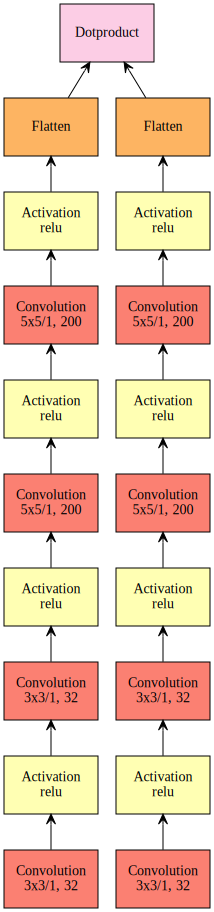

In [19]:
mx.viz.plot_network(net)

In [25]:
batch_size = 1250
s1 = (batch_size,3,13,13)
s2 = (batch_size,3,7,7)
net.infer_shape(left=s1,right=s1)

([(1250L, 3L, 13L, 13L),
  (32L, 3L, 3L, 3L),
  (32L,),
  (32L, 32L, 3L, 3L),
  (32L,),
  (200L, 32L, 5L, 5L),
  (200L,),
  (200L, 200L, 5L, 5L),
  (200L,),
  (1250L, 3L, 13L, 13L)],
 [(1250L, 33800L), (1250L, 33800L), (1250L,)],
 [])

In [27]:
dict(zip(net.list_arguments(),net.infer_shape(left=s1,right=s1)[0]))

{'bias0_blue': (32L,),
 'bias1_blue': (32L,),
 'bias2_blue': (200L,),
 'bias3_blue': (200L,),
 'left': (1250L, 3L, 13L, 13L),
 'right': (1250L, 3L, 13L, 13L),
 'weight0_blue': (32L, 3L, 3L, 3L),
 'weight1_blue': (32L, 32L, 3L, 3L),
 'weight2_blue': (200L, 32L, 5L, 5L),
 'weight3_blue': (200L, 200L, 5L, 5L)}

In [28]:
dict(zip(net2.list_arguments(),net2.infer_shape(left=s1,right=s1)[0]))

{'bias1_blue': (32L,),
 'bias2_blue': (32L,),
 'bias3_blue': (200L,),
 'bias4_blue': (200L,),
 'l1_blue': (32L, 3L, 3L, 3L),
 'l2_blue': (32L, 32L, 3L, 3L),
 'l3_blue': (200L, 32L, 5L, 5L),
 'l4_blue': (200L, 200L, 5L, 5L),
 'left': (1250L, 3L, 13L, 13L),
 'right': (1250L, 3L, 13L, 13L)}

In [22]:
def get_network2():
        left  = mx.sym.Variable('left')
        right = mx.sym.Variable('right')
        leftdownsample = mx.sym.Variable('left_downsample')
        rightdownsample= mx.sym.Variable('right_downsample')
        weight1_blue = mx.sym.Variable('l1_blue')
        weight2_blue = mx.sym.Variable('l2_blue')
        weight3_blue = mx.sym.Variable('l3_blue')
        weight4_blue = mx.sym.Variable('l4_blue')
        b1_blue = mx.sym.Variable('bias1_blue')
        b2_blue = mx.sym.Variable('bias2_blue')
        b3_blue = mx.sym.Variable('bias3_blue')
        b4_blue = mx.sym.Variable('bias4_blue')
        weight1_red  = mx.sym.Variable('l1_red')
        weight2_red  = mx.sym.Variable('l2_red')
        weight3_red  = mx.sym.Variable('l3_red')
        weight4_red  = mx.sym.Variable('l4_red')
        b1_red = mx.sym.Variable('bias1_red')
        b2_red = mx.sym.Variable('bias2_red')
        b3_red = mx.sym.Variable('bias3_red')
        b4_red = mx.sym.Variable('bias4_red')
        conv1_1_blue = mx.sym.Convolution(data=left, weight=weight1_blue,bias =b1_blue,kernel=(3,3),pad=(1,1),num_filter = 32)
        relu1_1_blue = mx.symbol.Activation(data=conv1_1_blue, act_type="relu")
        conv1_2_blue = mx.sym.Convolution(data=right,weight=weight1_blue,bias =b1_blue,kernel=(3,3),pad=(1,1),num_filter = 32)
        relu1_2_blue = mx.symbol.Activation(data=conv1_2_blue, act_type="relu")
        conv2_1_blue = mx.sym.Convolution(data=relu1_1_blue,weight=weight2_blue,bias = b2_blue,kernel=(3,3),pad=(1,1),num_filter = 32)
        relu2_1_blue = mx.symbol.Activation(data=conv2_1_blue, act_type="relu")
        conv2_2_blue = mx.sym.Convolution(data=relu1_2_blue,weight=weight2_blue,bias = b2_blue,kernel=(3,3),pad=(1,1),num_filter = 32)
        relu2_2_blue = mx.symbol.Activation(data=conv2_2_blue, act_type="relu")
        conv3_1_blue = mx.sym.Convolution(data=relu2_1_blue,weight=weight3_blue,bias = b3_blue,kernel=(5,5),pad=(2,2),num_filter = 200)
        relu3_1_blue = mx.symbol.Activation(data=conv3_1_blue, act_type="relu")
        conv3_2_blue = mx.sym.Convolution(data=relu2_2_blue,weight=weight3_blue,bias = b3_blue,kernel=(5,5),pad=(2,2),num_filter = 200)
        relu3_2_blue = mx.symbol.Activation(data=conv3_2_blue, act_type="relu")
        conv4_1_blue = mx.sym.Convolution(data=relu3_1_blue,weight=weight4_blue,bias = b4_blue,kernel=(5,5),pad=(2,2),num_filter = 200)
        relu4_1_blue = mx.symbol.Activation(data=conv4_1_blue, act_type="relu")
        conv4_2_blue = mx.sym.Convolution(data=relu3_2_blue,weight=weight4_blue,bias = b4_blue,kernel=(5,5),pad=(2,2),num_filter = 200)
        relu4_2_blue = mx.symbol.Activation(data=conv4_2_blue, act_type="relu")

        conv1_1_red = mx.sym.Convolution(data=leftdownsample,weight=weight1_red,bias = b1_red,kernel=(3,3),pad=(1,1),num_filter = 32)
        conv1_2_red = mx.sym.Convolution(data=rightdownsample,weight=weight1_red,bias = b1_red,kernel=(3,3),pad=(1,1),num_filter =32)
        conv2_1_red = mx.sym.Convolution(data=conv1_1_red,weight=weight2_red,bias = b2_red,kernel=(3,3),pad=(1,1),num_filter = 32)
        conv2_2_red = mx.sym.Convolution(data=conv1_2_red,weight=weight2_red,bias = b2_red,kernel=(3,3),pad=(1,1),num_filter = 32)
        conv3_1_red = mx.sym.Convolution(data=conv2_1_red,weight=weight3_red,bias = b3_red,kernel=(5,5),pad=(2,2),num_filter = 200)
        conv3_2_red = mx.sym.Convolution(data=conv2_2_red,weight=weight3_red,bias = b3_red,kernel=(5,5),pad=(2,2),num_filter = 200)
        conv4_1_red = mx.sym.Convolution(data=conv3_1_red,weight=weight4_red,bias = b4_red,kernel=(5,5),pad=(2,2),num_filter = 200)
        conv4_2_red = mx.sym.Convolution(data=conv3_2_red,weight=weight4_red,bias = b4_red,kernel=(5,5),pad=(2,2),num_filter = 200)

        f_blue1 = mx.sym.Flatten(data = relu4_1_blue)
        f_blue2 = mx.sym.Flatten(data = relu4_2_blue)
        f_red1  = mx.sym.Flatten(data = conv4_1_red)
        f_red2  = mx.sym.Flatten(data = conv4_2_red)
        #dot = Dot()
        #s = dot(x = f_blue1 ,y =f_blue2,name='dot_product1') #+ w2*dot(x = f_red1,y = f_red2,name='dot_product2')
        s = mx.sym.Dotproduct(   data1 = f_blue1, data2 = f_blue2 )
        net = mx.sym.Group([f_blue1,f_blue2,s])
        return net
net2 = get

In [23]:
net2.infer_shape(left=s1,right=s1)

([(1250L, 3L, 13L, 13L),
  (32L, 3L, 3L, 3L),
  (32L,),
  (32L, 32L, 3L, 3L),
  (32L,),
  (200L, 32L, 5L, 5L),
  (200L,),
  (200L, 200L, 5L, 5L),
  (200L,),
  (1250L, 3L, 13L, 13L)],
 [(1250L, 33800L), (1250L, 33800L), (1250L,)],
 [])